In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gym
import tensorflow as tf
from collections import deque
import random
from sklearn.decomposition import PCA
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
import plotly.graph_objects as go
from tensorflow.keras.models import Sequential, load_model
from sklearn.linear_model import LinearRegression,Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber

In [ ]:
# upload dataset
file_path = '/content/drive/MyDrive/ERP29 Homogenization Optimization/matrix_f1_f2_200,000.csv'
data = pd.read_csv(file_path)
print(data.head())

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


         y1         y2        x1        x2        x3        x4        x5  \
0  0.509838  29.871126  5.218985  5.397777  5.379121  5.034495  4.679806   
1  0.575812  21.760299  5.320928  5.758512  6.202190  6.213097  5.800003   
2  0.661856  23.925695  5.031183  4.988109  4.935486  5.071049  5.278536   
3  0.479243  29.308284  5.378384  5.912559  6.500275  6.716089  6.662687   
4  0.369678  28.512919  4.794109  4.602453  4.436202  4.273816  4.165630   

         x6        x7        x8  ...        x61        x62        x63  \
0  4.584021  4.663380  4.986155  ...  41.393265  46.727495  12.628864   
1  5.442692  5.487448  5.764109  ...  30.415500  45.615116  27.584300   
2  5.311304  5.211655  5.160902  ...  36.840886  18.470995  47.545833   
3  6.545332  6.298756  6.093468  ...  44.173243  24.883121  38.788141   
4  4.147377  3.913101  3.537255  ...  48.558070  27.261051  47.816105   

         x64        x65        x66        x67        x68        x69        x70  
0  43.017399  45.996712

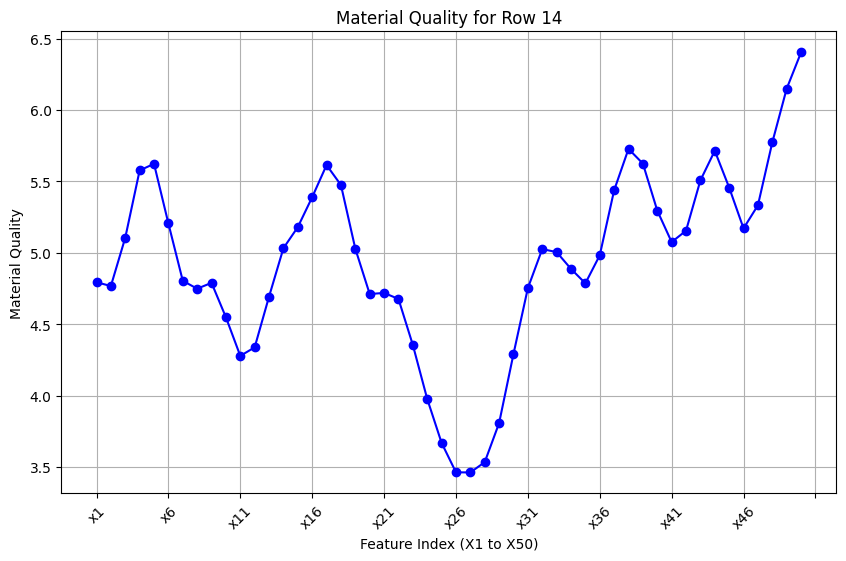

In [ ]:
# Plot the material_quality values
material_quality_row = data.iloc[13, data.columns.get_loc('x1'):data.columns.get_loc('x50')+1]
plt.figure(figsize=(10, 6))
plt.plot(material_quality_row.index, material_quality_row.values, marker='o', linestyle='-', color='b')
plt.xlabel('Feature Index (X1 to X50)')
plt.ylabel('Material Quality')
plt.title('Material Quality for Row 14')
plt.grid(True)
plt.xticks(range(data.columns.get_loc('x1')-2, data.columns.get_loc('x50'), 5), rotation=45)
plt.show()

<ipython-input-7-bef49cde43ff>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['x1'], shade=True, color='blue')


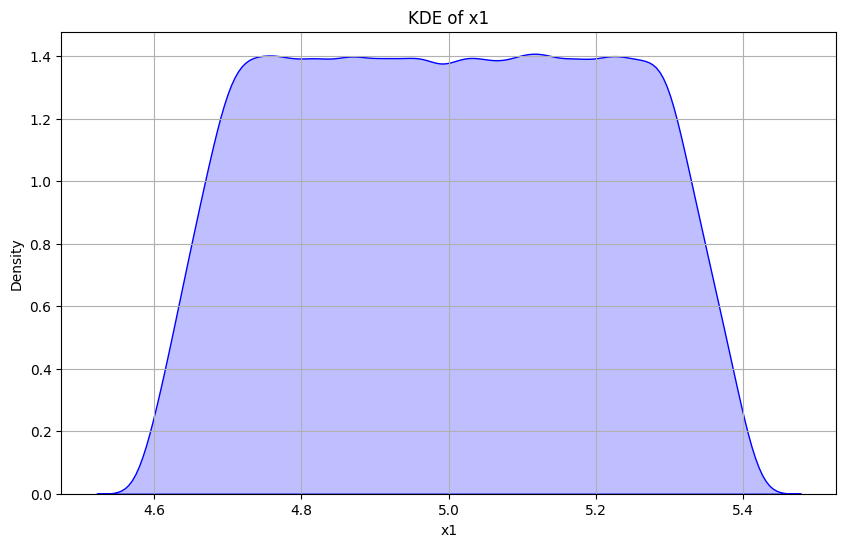

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Plot KDE for X1
plt.figure(figsize=(10, 6))
sns.kdeplot(data['x1'], shade=True, color='blue')
plt.xlabel('x1')
plt.ylabel('Density')
plt.title('KDE of x1')
plt.grid(True)
plt.show()


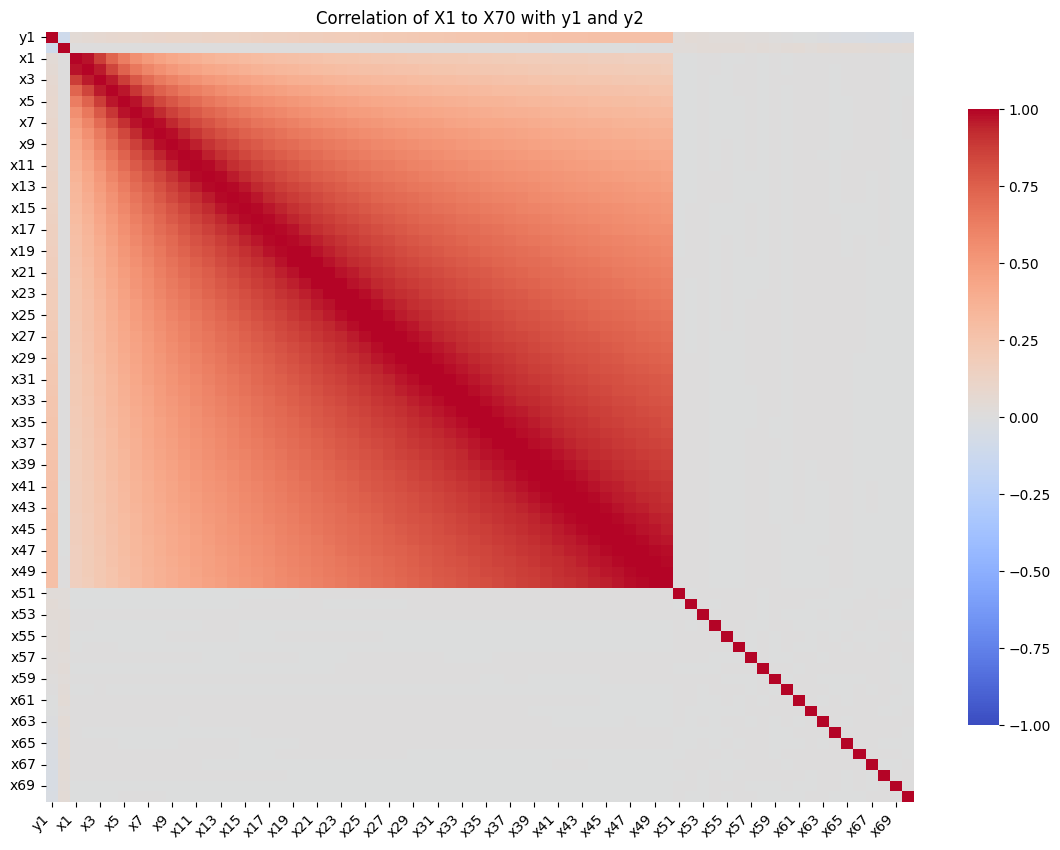

In [ ]:
corr_matrix = data.corr()
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix.iloc[:, :72], annot=False, cmap='coolwarm', vmin=-1, vmax=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation of X1 to X70 with y1 and y2')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()

**2.Modeling**

In [ ]:
# Prepare the data for the regression model
X = data.drop(columns=['y1', 'y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalize the feature matrix X
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Important: transform only, no fit on test data

# Initialize and fit the linear regression model with the normalized training data
model = LinearRegression()
model.fit(X_train_scaled, y_train)

# Predict on the test data
y_pred = model.predict(X_test_scaled)

# Get the coefficients, intercept, and R² score for the test set
intercept = model.intercept_
coefficients = model.coef_
r2 = r2_score(y_test, y_pred)  # Calculating R² score on the test data

print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("R² Score on Test Data:", r2)

Intercept: 0.543200019574898
Coefficients: [ 5.01976684e+09 -1.24984392e+10  1.44518500e+10 -1.20906838e+10
  8.89939043e+09 -6.18014582e+09  4.15991993e+09 -2.74829684e+09
  1.79239743e+09 -1.15746781e+09  7.41595384e+08 -4.72198578e+08
  2.99115244e+08 -1.88625269e+08  1.18534547e+08 -7.42796971e+07
  4.64283075e+07 -2.89534834e+07  1.80156453e+07 -1.11859854e+07
  6.93514775e+06 -4.29627551e+06  2.65884483e+06 -1.64320405e+06
  1.01456526e+06 -6.25830972e+05  3.85657111e+05 -2.37473442e+05
  1.46134140e+05 -8.98616139e+04  5.52170195e+04 -3.39024436e+04
  2.08037356e+04 -1.27613877e+04  7.82507881e+03 -4.79663390e+03
  2.93922191e+03 -1.80035798e+03  1.10250840e+03 -6.74821236e+02
  4.12814126e+02 -2.52395075e+02  1.54236992e+02 -9.41945958e+01
  5.74558957e+01 -3.48518715e+01  2.08672762e+01 -1.20507340e+01
  6.21124077e+00 -1.86515188e+00  6.84070587e-03  1.03540421e-02
  1.05663538e-02  8.53300095e-03  7.90405273e-03  7.15589523e-03
  4.89139557e-03  4.87184525e-03  2.40230560e-0

In [ ]:
import statsmodels.api as sm

# Assuming 'X' and 'y' are your predictors and target variable from a DataFrame
X = sm.add_constant(X)  # Adding a constant to include an intercept in the regression model

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression which includes the p-values
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     355.9
Date:                Thu, 15 Aug 2024   Prob (F-statistic):               0.00
Time:                        21:10:09   Log-Likelihood:                -19925.
No. Observations:              200000   AIC:                         3.995e+04
Df Residuals:                  199950   BIC:                         4.046e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.3279      0.033     10.040      0.0

In [ ]:
# Plot the actual vs. predicted values for y1
fig = go.Figure()

# Actual vs. Predicted
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=y_test,
        y=y_pred,
        marker=dict(
            color='rgba(40, 40, 250, 0.3)',
            size=5,
        ),
        name='Actual vs Predicted'
    )
)

# Reduce the size of the markers
fig.update_traces(marker=dict(size=4))

# Add a 45-degree line to show the perfect prediction
fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False,
        name='Perfect Prediction Line'
    )
)

# Update layout
fig.update_layout(
    title="Actual vs Predicted y1 Values",
    xaxis_title="Actual y1",
    yaxis_title="Predicted y1",
    width=700,
    height=500
)

# Show plot
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#basic linear regression model
# Prepare the data for the regression model
X = data.drop(columns=['y1', 'y2'])
y = data['y2']

# Split the data into training and testing sets (optional)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Generate predictions
y_pred = model.predict(X_test)

# Get the coefficients and R² score
intercept = model.intercept_
coefficients = model.coef_
r2 = model.score(X_test, y_test)

print("Coefficients:", coefficients)
print("R² Score:", r2)

Coefficients: [-5.18134933e+10  6.12648962e+10 -4.48876255e+10  2.90429298e+10
 -1.80281193e+10  1.10260623e+10 -6.70693159e+09  4.07143712e+09
 -2.46969384e+09  1.49766818e+09 -9.08117549e+08  5.50619129e+08
 -3.33852064e+08  2.02420464e+08 -1.22730884e+08  7.44137116e+07
 -4.51182183e+07  2.73558911e+07 -1.65863095e+07  1.00565411e+07
 -6.09743902e+06  3.69697298e+06 -2.24153246e+06  1.35907597e+06
 -8.24028797e+05  4.99621190e+05 -3.02927567e+05  1.83669014e+05
 -1.11360787e+05  6.75196175e+04 -4.09383655e+04  2.48215347e+04
 -1.50492357e+04  9.12409215e+03 -5.53177721e+03  3.35376196e+03
 -2.03337311e+03  1.23301232e+03 -7.47737381e+02  4.53282575e+02
 -2.74550535e+02  1.66368801e+02 -1.01053099e+02  6.14194965e+01
 -3.71707764e+01  2.22973366e+01 -1.30836372e+01  7.44577789e+00
 -3.88662720e+00  1.21247673e+00  8.63456726e-03  1.10549927e-02
  1.77040100e-02  1.54247284e-02  1.67579651e-02  1.79719925e-02
  1.71928406e-02  2.10628510e-02  1.70764923e-02  1.81770325e-02
  1.7405509

In [ ]:
# Plot the actual vs. predicted values
fig = go.Figure()

# Actual vs. Predicted
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=y_test,
        y=y_pred,
        marker=dict(
            color='rgba(40, 40, 250, 0.3)',
            size=5,
        ),
        name='Actual vs Predicted'
    )
)


# Reduce the size of the markers
fig.update_traces(marker=dict(size=4))

# Update layout
fig.update_layout(
    title="Actual vs Predicted y2 Values",
    xaxis_title="Actual y2",
    yaxis_title="Predicted y2",
    width=700,
    height=500
)

# Show plot
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#use Lasso with cross-validation for selection of α (standardization required)
# Prepare the data for the regression model
X = data.drop(columns=['y1','y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with StandardScaler and Lasso
pipeline = make_pipeline(StandardScaler(), Lasso())

# Set up the parameter grid to search for the best alpha
param_grid = {
    'lasso__alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
}

# Use GridSearchCV to find the best alpha with cross-validation on the training set
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

# Extract the best model and its parameters
best_alpha = grid_search.best_params_['lasso__alpha']
best_model = grid_search.best_estimator_
best_r2 = grid_search.best_score_

# Get the coefficients and intercept from the best model
intercept = best_model.named_steps['lasso'].intercept_
coefficients = best_model.named_steps['lasso'].coef_

# Calculate predictions on the test set
y_pred = best_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse = mean_squared_error(y_test, y_pred)

# Perform cross-validation on the training set to get a better estimate of the model's performance
cv_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse = -cv_scores.mean()  # Take the mean of the negative MSE scores and negate it

cv_r2_scores = cross_val_score(best_model, X_train, y_train, cv=5, scoring='r2')
cv_r2 = cv_r2_scores.mean()

print("Best Alpha:", best_alpha)
print("Intercept:", intercept)
print("Coefficients:", coefficients)
print("Best R² Score from Grid Search:", best_r2)
print("Mean Squared Error (MSE) on Test Set:", mse)
print("Cross-Validated Mean Squared Error (MSE) on Train Set:", cv_mse)
print("Cross-Validated R² Score on Train Set:", cv_r2)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.997e+00, tolerance: 4.897e-01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.605e+00, tolerance: 4.888e-01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.542e+00, tolerance: 4.895e-01

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_des

Best Alpha: 0.0001
Intercept: 0.5418187987038736
Coefficients: [ 0.00261581  0.          0.00029771  0.         -0.         -0.00316199
 -0.         -0.         -0.00073488 -0.          0.          0.
  0.00064583  0.         -0.         -0.         -0.         -0.00667611
 -0.         -0.         -0.00198722 -0.00090358 -0.          0.
  0.         -0.         -0.          0.          0.0024522   0.
  0.          0.          0.          0.          0.          0.
  0.          0.0158591   0.0052415   0.          0.          0.
  0.00463793  0.          0.          0.          0.0032446   0.01376007
  0.00774694  0.03327642  0.00835282  0.00981925  0.0089299   0.00814566
  0.0076869   0.00561427  0.00444347  0.00375288  0.00226464  0.00202443
 -0.00085589 -0.00030186 -0.00450612 -0.00327661 -0.00816011 -0.00711117
 -0.00766591 -0.01116113 -0.01181733 -0.00902249]
Best R² Score from Grid Search: 0.0904460606181341
Mean Squared Error (MSE) on Test Set: 0.06834637876237913
Cross-Validated

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.611e+01, tolerance: 4.903e-01



In [ ]:
# Get the feature names and coefficients from the best model; potential importance of features, more need to be explored by feature importance
feature_names = X.columns
coefficients = best_model.named_steps['lasso'].coef_

# Create a DataFrame with feature names and their corresponding coefficients
feature_coefficients = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Filter out non-zero coefficients and sort them in descending order
non_zero_coefficients = feature_coefficients[feature_coefficients['Coefficient'] != 0]
non_zero_coefficients_sorted = non_zero_coefficients.sort_values(by='Coefficient', ascending=False)

print(non_zero_coefficients_sorted)

   Feature  Coefficient
49     x50     0.055360
41     x42     0.013029
51     x52     0.011019
45     x46     0.009379
52     x53     0.009360
53     x54     0.008802
54     x55     0.008724
50     x51     0.008034
32     x33     0.004628
57     x58     0.003952
55     x56     0.003178
58     x59     0.002472
6       x7     0.002273
59     x60     0.002072
56     x57     0.001951
33     x34     0.001732
5       x6     0.001201
60     x61    -0.000289
63     x64    -0.002630
64     x65    -0.003269
13     x14    -0.004376
21     x22    -0.006034
65     x66    -0.006521
66     x67    -0.008298
67     x68    -0.009320
69     x70    -0.009784
62     x63    -0.010369
68     x69    -0.015228


In [ ]:
#Random Forest (Discarded)
# Prepare the data
X = data.drop(columns=['y1', 'y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the Random Forest model with pre-selected parameters
rf_model = RandomForestRegressor(
    n_estimators=100,      # Number of trees in the forest
    max_depth=10,          # Maximum depth of the tree
    min_samples_split=2,   # Minimum number of samples required to split an internal node
    min_samples_leaf=1,    # Minimum number of samples required to be at a leaf node
    bootstrap=True,        # Whether bootstrap samples are used when building trees
    random_state=42        # Set the random seed for reproducibility
)

# Fit the model on the training data
rf_model.fit(X_train, y_train)

# Calculate predictions on the test set for baseline comparison
y_pred_rf = rf_model.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse_rf = mean_squared_error(y_test, y_pred_rf)

# Perform cross-validation to get a better estimate of the model's performance
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_rf = -cv_scores_rf.mean()  # Take the mean of the negative MSE scores and negate it


print("Mean Squared Error (MSE) on Test Set:", mse_rf)
print("Cross-Validated Mean Squared Error (MSE) on Train Set:", cv_mse_rf)

Mean Squared Error (MSE) on Test Set: 0.03775332656122441
Cross-Validated Mean Squared Error (MSE) on Train Set: 0.03609228923026318
Cross-Validated R² Score on Train Set: 0.5226484094775188


In [ ]:
# Plot the actual vs. predicted values for y1
fig = go.Figure()

# Actual vs. Predicted
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=y_test,
        y=y_pred_rf,
        marker=dict(
            color='rgba(40, 40, 250, 0.3)',
            size=5,
        ),
        name='Actual vs Predicted'
    )
)

# Add a 45-degree line to show the perfect prediction
fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False,
        name='Perfect Prediction Line'
    )
)

# Reduce the size of the markers
fig.update_traces(marker=dict(size=4))

# Update layout
fig.update_layout(
    title="Actual vs Predicted y1 Values (Random Forest)",
    xaxis_title="Actual y1",
    yaxis_title="Predicted y1",
    width=700,
    height=500
)

# Show plot
fig.show()

In [ ]:
#SVR (Discarded)
# Prepare the data
X = data.drop(columns=['y1', 'y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with PCA, StandardScaler, and SVR
pipeline_svr_pca = Pipeline([
    ('pca', PCA(n_components=0.95)),  # Retain 95% of the variance
    ('scaler', StandardScaler()),
    ('svr', SVR(C=1.0, epsilon=0.1, kernel='rbf'))
])

# Fit the model on the training data
pipeline_svr_pca.fit(X_train, y_train)

# Calculate predictions on the test set for baseline comparison
y_pred_svr = pipeline_svr_pca.predict(X_test)

# Calculate Mean Squared Error (MSE) on the test set
mse_svr = mean_squared_error(y_test, y_pred_svr)

# Perform cross-validation on the training set to get a better estimate of the model's performance
cv_scores_svr = cross_val_score(pipeline_svr_pca, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_mse_svr = -cv_scores_svr.mean()  # Take the mean of the negative MSE scores and negate it

cv_r2_scores_svr = cross_val_score(pipeline_svr_pca, X_train, y_train, cv=5, scoring='r2')
cv_r2_svr = cv_r2_scores_svr.mean()

print("Mean Squared Error (MSE) on Test Set:", mse_svr)
print("Cross-Validated Mean Squared Error (MSE) on Train Set:", cv_mse_svr)
print("Cross-Validated R² Score on Train Set:", cv_r2_svr)

Mean Squared Error (MSE) on Test Set: 0.05967735669613786
Cross-Validated Mean Squared Error (MSE) on Train Set: 0.06018215291635842
Cross-Validated R² Score on Train Set: 0.20344259720867486


In [ ]:
# Plot the actual vs. predicted values for y1
fig = go.Figure()

# Actual vs. Predicted
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=y_test,
        y=y_pred_svr,
        marker=dict(
            color='rgba(40, 40, 250, 0.3)',
            size=5,
        ),
        name='Actual vs Predicted'
    )
)

# Add a 45-degree line to show the perfect prediction
fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False,
        name='Perfect Prediction Line'
    )
)

# Reduce the size of the markers
fig.update_traces(marker=dict(size=4))

# Update layout
fig.update_layout(
    title="Actual vs Predicted y1 Values (SVR)",
    xaxis_title="Actual y1",
    yaxis_title="Predicted y1",
    width=700,
    height=500
)

# Show plot
fig.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



In [ ]:
#XGBoost model without manully select features (automate by L1)
# Prepare the data
X = data.drop(columns=['y1', 'y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the XGBoost regressor with L1 regularization (alpha) and specified hyperparameters
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=200,
    max_depth=7,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    alpha=0.5,  # L1 regularization parameter
    random_state=42
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

# Evaluate on the test set
y_pred = xgb_model.predict(X_test)
test_mse = mean_squared_error(y_test, y_pred)

print("Test MSE:", test_mse)

# Output the importance of features
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df.head(10))  # Display the top 10 features

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Test MSE: 0.02534538989728545
   Feature  Importance
43     x44    0.125217
46     x47    0.078332
42     x43    0.071201
45     x46    0.049210
44     x45    0.039020
41     x42    0.036575
47     x48    0.029035
8       x9    0.026094
40     x41    0.022336
48     x49    0.021896


In [ ]:
# Visualize the actual vs. predicted values for y1
fig = go.Figure()

# Actual vs. Predicted
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=y_test,
        y=y_pred,
        marker=dict(
            color='rgba(40, 40, 250, 0.3)',
            size=5,
        ),
        name='Actual vs Predicted'
    )
)

# Add a 45-degree line to show the perfect prediction
fig.add_trace(
    go.Scatter(
        x=[y_test.min(), y_test.max()],
        y=[y_test.min(), y_test.max()],
        mode='lines',
        line=dict(color='red', dash='dash'),
        showlegend=False,
        name='Perfect Prediction Line'
    )
)

# Update layout
fig.update_layout(
    title="Actual vs Predicted y1 Values (XGBoost)",
    xaxis_title="Actual y1",
    yaxis_title="Predicted y1",
    width=700,
    height=500
)

# Show plot
fig.show()

In [ ]:
#MLP
# Prepare the data
X = data.drop(columns=['y1','y2'])
y = data['y1']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Build the MLP model
model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='linear'))

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

# Evaluate the model
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test MSE: {test_loss}")

# Predict on test data
y_pred = model.predict(X_test_scaled)

# Display some predictions
print(y_pred[:5])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 0.0812 - val_loss: 0.0311
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0339 - val_loss: 0.0292
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0295 - val_loss: 0.0305
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - loss: 0.0272 - val_loss: 0.0261
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - loss: 0.0247 - val_loss: 0.0260
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - loss: 0.0236 - val_loss: 0.0258
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0232 - val_loss: 0.0283
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - loss: 0.0223 - val_loss: 0.0283
Epoch 9/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 12s 5ms/step - loss: 0.0219 - val_loss: 0.0243
Epoch 10/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 0.0212 - val_loss: 0.0215
Epoch 11/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - loss: 0.0208 - val_loss: 0.0236
Epoch 12/100
200

[[0.515339  ]
 [0.32498482]
 [0.38617748]
 [0.31100106]
 [0.40688747]]


In [ ]:
#LSTM
X = data.drop(columns=['y1','y2'])
y = data['y1']

# Since there is no notion of time steps, just make sure the input is 3D # But we treat all 70 features as one time step # X is (samples, features) and we need (samples, time steps, features) # Here, time steps = 1 since all features are input at the same time
X = X.values.reshape((X.shape[0], 1, X.shape[1]))

# Divide the training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardised data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Constructing the LSTM model
model = Sequential()
model.add(LSTM(64, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2]), activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='linear'))

# compilation model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Training Models
history = model.fit(X_train_scaled, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)

# assessment model
test_loss = model.evaluate(X_test_scaled, y_test)
print(f"Test MSE: {test_loss}")

# Predictive test data
y_pred = model.predict(X_test_scaled)

# Showing some predicted results
print(y_pred[:5])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 74s 5ms/step - loss: 0.0593 - val_loss: 0.0284
Epoch 2/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0330 - val_loss: 0.0270
Epoch 3/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 6ms/step - loss: 0.0303 - val_loss: 0.0255
Epoch 4/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - loss: 0.0279 - val_loss: 0.0247
Epoch 5/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - loss: 0.0272 - val_loss: 0.0233
Epoch 6/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0252 - val_loss: 0.0221
Epoch 7/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0253 - val_loss: 0.0222
Epoch 8/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.0243 - val_loss: 0.0211
Epoch 9/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - loss: 0.0236 - val_loss: 0.0212
Epoch 10/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0230 - val_loss: 0.0205
Epoch 11/100
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 0.0232 - val_loss: 0.0205
Epoch 12/100
2

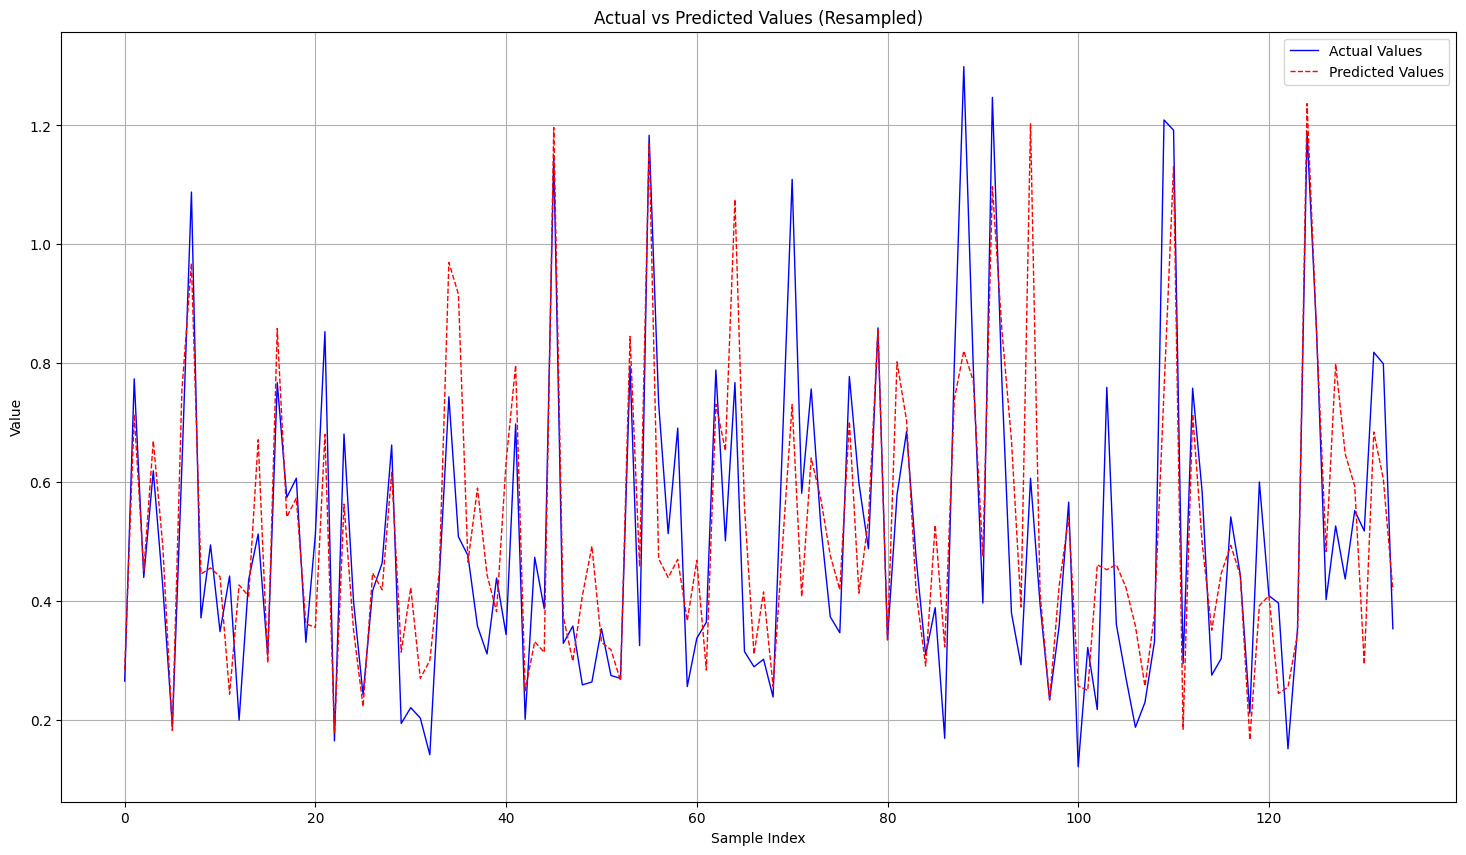

In [ ]:
# Resample the actual data for clarity
resample_factor = 15  # Adjust this factor to reduce the number of points for clarity
y_test_resampled = y_test[::resample_factor]
y_pred_resampled = y_pred[::resample_factor]
sample_indices = np.arange(len(y_test_resampled))

# Plotting
plt.figure(figsize=(18, 10))  # Larger figure size for better clarity
plt.plot(sample_indices, y_test_resampled, label='Actual Values', color='blue', linewidth=1)
plt.plot(sample_indices, y_pred_resampled, label='Predicted Values', color='red', linestyle='dashed', linewidth=1)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values (Resampled)')
plt.legend()
plt.grid(True)
plt.show()